In [4]:
import torch
from tqdm import tqdm
from torch import nn, optim
from torch.nn import init
import pandas as pd
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("../../data2/data.csv").drop(columns = ["id", "source", 
                                                       "latitude", "longitude", 
                                                           "L_clinic", "L_place_of_worship",
                                                           "L_hospital", "L_kindergarten",
                                                           "SL_baghramyan_subway"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850 entries, 0 to 1849
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         1850 non-null   int64  
 1   price                              1850 non-null   float64
 2   area                               1850 non-null   float64
 3   rooms                              1850 non-null   float64
 4   floor                              1850 non-null   float64
 5   storeys                            1850 non-null   float64
 6   bathroom_count                     1850 non-null   float64
 7   new_building                       1850 non-null   int64  
 8   F_Balcony                          1850 non-null   int64  
 9   F_Internet                         1850 non-null   int64  
 10  F_Security                         1850 non-null   int64  
 11  F_Elevator                         1850 non-null   int64

In [5]:
class TabularFFNNSimple(nn.Module):
    def __init__(self, input_size, output_size, dropout_prob=0.4):
        super(TabularFFNNSimple, self).__init__()
        hidden_size = 64
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.25),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.18),
            nn.Linear(hidden_size, output_size)
        )
        
        for m in self.ffnn:
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0)

    def forward(self, x):
        x = x.float()
        # print(x)
        x = x.view(x.size(0), -1)
        x = self.ffnn(x)
        return x
    
# Split the data into features and target
X = data.drop('price', axis=1)
y = data['price']

# Standardize the features
device = torch.device("cpu")
# Convert to PyTorch tensors
X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


# Split the data into training and combined validation and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor,
                                                            test_size=0.4, random_state=42)

# Split the combined validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Create DataLoader for training, validation, and testing
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 512
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Check if the dimensions match the expected input size for the model
input_size = X_train.shape[1]

# Output
# input_size, train_loader, test_loader

model = TabularFFNNSimple(
    input_size = input_size,
    output_size = 1
)
model.to(device)

num_epochs = 300000
train_losses = []
val_losses = []
epochs_suc = [] # to have a reference to it
grad_norms = []

def get_gradient_norm(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

In [ ]:
optimizer = optim.Adam(
    model.parameters(), 
    lr=1e-2,
    weight_decay=3e-4
)
criterion = torch.nn.MSELoss()
criterion_abs = torch.nn.L1Loss()
criterion = criterion_abs

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.999, 
    patience=100, 
    verbose=True
)

for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    running_loss = 0.0
    l1_losses = []
    grad_norm = 0
    for tuple_ in train_loader:
        datas, prices = tuple_
        optimizer.zero_grad()
        outputs = model(datas)
        prices_viewed = prices.view(-1, 1).float()
        loss = criterion(outputs, prices_viewed)
        loss.backward()
        grad_norm += get_gradient_norm(model)
        optimizer.step()

        running_loss += loss.item()
        
    grad_norms.append(grad_norm / len(train_loader))
    train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for tuple_ in val_loader:
            datas, prices = tuple_
            outputs = model(datas)  # Forward pass
            prices_viewed = prices.view(-1, 1).float()
            loss = criterion(outputs, prices_viewed)  # Compute loss
            val_loss += loss.item()  # Accumulate the loss
            l1_losses.append(criterion_abs(outputs, prices_viewed))

    val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
    l1_mean_loss = sum(l1_losses) / len(l1_losses)
    # Print epoch's summary
    epochs_suc.append(epoch)
    scheduler.step(val_losses[-1])
    if epoch % 100 == 0:
        tl = f"Training Loss: {int(train_losses[-1])}"
        vl = f"Validation Loss: {int(val_losses[-1])}"
        l1 = f"L1: {int(l1_mean_loss)}"
        dl = f'Epoch {epoch+1}, {tl}, {vl}, {grad_norms[-1]}'
        print(dl)

Epoch 1, Training Loss: 240723, Validation Loss: 244170, 5.282248829189155
Epoch 101, Training Loss: 62587, Validation Loss: 61138, 66305.02547601871
Epoch 201, Training Loss: 62410, Validation Loss: 63473, 149536.84273430044
Epoch 301, Training Loss: 62510, Validation Loss: 75158, 163751.0563065162
Epoch 00345: reducing learning rate of group 0 to 9.9900e-03.
Epoch 401, Training Loss: 59250, Validation Loss: 57868, 183575.72304144167
Epoch 00488: reducing learning rate of group 0 to 9.9800e-03.
Epoch 501, Training Loss: 59835, Validation Loss: 54852, 194913.03632342978
Epoch 00589: reducing learning rate of group 0 to 9.9700e-03.
Epoch 601, Training Loss: 59798, Validation Loss: 61881, 131192.32429570457
Epoch 00690: reducing learning rate of group 0 to 9.9601e-03.
Epoch 701, Training Loss: 62775, Validation Loss: 87344, 243632.14424374118
Epoch 00791: reducing learning rate of group 0 to 9.9501e-03.
Epoch 801, Training Loss: 56008, Validation Loss: 61206, 188560.8657432499
Epoch 0089

Epoch 06182: reducing learning rate of group 0 to 9.4457e-03.
Epoch 6201, Training Loss: 50905, Validation Loss: 58843, 131365.2797179419
Epoch 06283: reducing learning rate of group 0 to 9.4362e-03.
Epoch 6301, Training Loss: 49894, Validation Loss: 61585, 93888.239554798
Epoch 06384: reducing learning rate of group 0 to 9.4268e-03.
Epoch 6401, Training Loss: 53053, Validation Loss: 61761, 139678.17225663038
Epoch 06485: reducing learning rate of group 0 to 9.4174e-03.
Epoch 6501, Training Loss: 51919, Validation Loss: 56042, 100060.59379270564
Epoch 06586: reducing learning rate of group 0 to 9.4079e-03.
Epoch 6601, Training Loss: 51047, Validation Loss: 69333, 143968.7712864515
Epoch 06687: reducing learning rate of group 0 to 9.3985e-03.
Epoch 6701, Training Loss: 50943, Validation Loss: 59543, 94307.71941668977
Epoch 06788: reducing learning rate of group 0 to 9.3891e-03.
Epoch 6801, Training Loss: 52932, Validation Loss: 58114, 134501.94969033054
Epoch 06889: reducing learning ra

Epoch 12141: reducing learning rate of group 0 to 8.9042e-03.
Epoch 12201, Training Loss: 51089, Validation Loss: 57150, 114910.0025381559
Epoch 12242: reducing learning rate of group 0 to 8.8953e-03.
Epoch 12301, Training Loss: 53388, Validation Loss: 62761, 87158.64843925029
Epoch 12343: reducing learning rate of group 0 to 8.8864e-03.
Epoch 12401, Training Loss: 50802, Validation Loss: 64639, 76768.99716838874
Epoch 12444: reducing learning rate of group 0 to 8.8775e-03.
Epoch 12501, Training Loss: 50268, Validation Loss: 57653, 127230.39288752315
Epoch 12545: reducing learning rate of group 0 to 8.8687e-03.
Epoch 12601, Training Loss: 49900, Validation Loss: 56472, 124449.08308937783
Epoch 12646: reducing learning rate of group 0 to 8.8598e-03.
Epoch 12701, Training Loss: 48911, Validation Loss: 58599, 83766.61602467044
Epoch 12747: reducing learning rate of group 0 to 8.8509e-03.
Epoch 12801, Training Loss: 50966, Validation Loss: 66062, 83344.36688111977
Epoch 12848: reducing lea

Epoch 18201, Training Loss: 47172, Validation Loss: 53667, 68146.387195258
Epoch 18206: reducing learning rate of group 0 to 8.4022e-03.
Epoch 18301, Training Loss: 48713, Validation Loss: 54129, 68497.89515597101
Epoch 18307: reducing learning rate of group 0 to 8.3938e-03.
Epoch 18401, Training Loss: 45058, Validation Loss: 53269, 83384.23653381236
Epoch 18408: reducing learning rate of group 0 to 8.3854e-03.
Epoch 18501, Training Loss: 44869, Validation Loss: 55606, 69918.95118578558
Epoch 18509: reducing learning rate of group 0 to 8.3771e-03.
Epoch 18601, Training Loss: 46786, Validation Loss: 58549, 83189.55451867374
Epoch 18610: reducing learning rate of group 0 to 8.3687e-03.
Epoch 18701, Training Loss: 47096, Validation Loss: 68881, 87735.34928951973
Epoch 18711: reducing learning rate of group 0 to 8.3603e-03.
Epoch 18801, Training Loss: 47386, Validation Loss: 55306, 77117.66002872684
Epoch 18829: reducing learning rate of group 0 to 8.3519e-03.
Epoch 18901, Training Loss: 4

Epoch 24301, Training Loss: 40470, Validation Loss: 52125, 90676.88579248777
Epoch 24312: reducing learning rate of group 0 to 7.9285e-03.
Epoch 24401, Training Loss: 43471, Validation Loss: 51384, 74150.34453216875
Epoch 24413: reducing learning rate of group 0 to 7.9206e-03.
Epoch 24501, Training Loss: 41790, Validation Loss: 60529, 65486.42073662996
Epoch 24514: reducing learning rate of group 0 to 7.9127e-03.
Epoch 24601, Training Loss: 43853, Validation Loss: 54604, 61221.72209837028
Epoch 24615: reducing learning rate of group 0 to 7.9048e-03.
Epoch 24701, Training Loss: 42003, Validation Loss: 58211, 62923.97498912074
Epoch 24716: reducing learning rate of group 0 to 7.8969e-03.
Epoch 24801, Training Loss: 43500, Validation Loss: 57811, 67068.21805279015
Epoch 24817: reducing learning rate of group 0 to 7.8890e-03.
Epoch 24901, Training Loss: 42109, Validation Loss: 50950, 63357.22572416529
Epoch 24918: reducing learning rate of group 0 to 7.8811e-03.
Epoch 25001, Training Loss:

Epoch 30301, Training Loss: 44880, Validation Loss: 48343, 59074.52452782627
Epoch 30307: reducing learning rate of group 0 to 7.4741e-03.
Epoch 30401, Training Loss: 43003, Validation Loss: 59550, 56801.00054208445
Epoch 30408: reducing learning rate of group 0 to 7.4666e-03.
Epoch 30501, Training Loss: 40165, Validation Loss: 54040, 61296.776127930956
Epoch 30509: reducing learning rate of group 0 to 7.4591e-03.
Epoch 30601, Training Loss: 39773, Validation Loss: 52137, 76774.6716438546
Epoch 30610: reducing learning rate of group 0 to 7.4517e-03.
Epoch 30701, Training Loss: 38696, Validation Loss: 59485, 62127.242468233024
Epoch 30711: reducing learning rate of group 0 to 7.4442e-03.
Epoch 30801, Training Loss: 41291, Validation Loss: 50983, 48870.00164494194
Epoch 30812: reducing learning rate of group 0 to 7.4368e-03.
Epoch 30901, Training Loss: 40796, Validation Loss: 52091, 72006.31751231088
Epoch 30913: reducing learning rate of group 0 to 7.4293e-03.
Epoch 31001, Training Loss

Epoch 36301, Training Loss: 38993, Validation Loss: 52286, 84278.2498711257
Epoch 36304: reducing learning rate of group 0 to 7.0456e-03.
Epoch 36401, Training Loss: 38998, Validation Loss: 50856, 50855.67149341248
Epoch 36405: reducing learning rate of group 0 to 7.0386e-03.
Epoch 36501, Training Loss: 41682, Validation Loss: 56715, 57326.6342232477
Epoch 36506: reducing learning rate of group 0 to 7.0316e-03.
Epoch 36601, Training Loss: 39377, Validation Loss: 50624, 71763.1944738031
Epoch 36607: reducing learning rate of group 0 to 7.0245e-03.
Epoch 36701, Training Loss: 39259, Validation Loss: 52190, 58882.30051599076
Epoch 36708: reducing learning rate of group 0 to 7.0175e-03.
Epoch 36801, Training Loss: 38783, Validation Loss: 50130, 62422.12746146304
Epoch 36809: reducing learning rate of group 0 to 7.0105e-03.
Epoch 36901, Training Loss: 40031, Validation Loss: 54864, 79754.90182259923
Epoch 36910: reducing learning rate of group 0 to 7.0035e-03.
Epoch 37001, Training Loss: 39

Epoch 42201, Training Loss: 39981, Validation Loss: 51214, 92722.79223123241
Epoch 42263: reducing learning rate of group 0 to 6.6418e-03.
Epoch 42301, Training Loss: 39249, Validation Loss: 54859, 79574.71571581582
Epoch 42364: reducing learning rate of group 0 to 6.6351e-03.
Epoch 42401, Training Loss: 37615, Validation Loss: 50955, 76428.53197524308
Epoch 42465: reducing learning rate of group 0 to 6.6285e-03.
Epoch 42501, Training Loss: 40070, Validation Loss: 52486, 73400.67457873016
Epoch 42566: reducing learning rate of group 0 to 6.6219e-03.
Epoch 42601, Training Loss: 39381, Validation Loss: 51118, 85289.3084712585
Epoch 42667: reducing learning rate of group 0 to 6.6153e-03.
Epoch 42701, Training Loss: 38220, Validation Loss: 58607, 63008.502536454005
Epoch 42768: reducing learning rate of group 0 to 6.6086e-03.
Epoch 42801, Training Loss: 35026, Validation Loss: 56507, 57250.15358084472
Epoch 42869: reducing learning rate of group 0 to 6.6020e-03.
Epoch 42901, Training Loss:

Epoch 48201, Training Loss: 40628, Validation Loss: 56557, 68643.28576766989
Epoch 48222: reducing learning rate of group 0 to 6.2611e-03.
Epoch 48301, Training Loss: 38806, Validation Loss: 54478, 71094.30177212345
Epoch 48323: reducing learning rate of group 0 to 6.2548e-03.
Epoch 48401, Training Loss: 35066, Validation Loss: 49688, 58302.52283497533
Epoch 48424: reducing learning rate of group 0 to 6.2486e-03.
Epoch 48501, Training Loss: 37552, Validation Loss: 60360, 72880.20805357
Epoch 48525: reducing learning rate of group 0 to 6.2423e-03.
Epoch 48601, Training Loss: 39260, Validation Loss: 58390, 81838.89140278219
Epoch 48626: reducing learning rate of group 0 to 6.2361e-03.
Epoch 48701, Training Loss: 39738, Validation Loss: 50810, 65933.92058548862
Epoch 48727: reducing learning rate of group 0 to 6.2298e-03.
Epoch 48801, Training Loss: 37128, Validation Loss: 51035, 67979.4671154582
Epoch 48828: reducing learning rate of group 0 to 6.2236e-03.
Epoch 48901, Training Loss: 360

Epoch 54181: reducing learning rate of group 0 to 5.9022e-03.
Epoch 54201, Training Loss: 37284, Validation Loss: 52431, 68393.36867514825
Epoch 54282: reducing learning rate of group 0 to 5.8963e-03.
Epoch 54301, Training Loss: 36251, Validation Loss: 58011, 59164.293666189245
Epoch 54383: reducing learning rate of group 0 to 5.8904e-03.
Epoch 54401, Training Loss: 39513, Validation Loss: 50683, 75585.19238488509
Epoch 54484: reducing learning rate of group 0 to 5.8845e-03.
Epoch 54501, Training Loss: 36755, Validation Loss: 59015, 59798.15783923527
Epoch 54585: reducing learning rate of group 0 to 5.8786e-03.
Epoch 54601, Training Loss: 34637, Validation Loss: 50060, 68064.78578546659
Epoch 54686: reducing learning rate of group 0 to 5.8727e-03.
Epoch 54701, Training Loss: 34806, Validation Loss: 60294, 77913.14038284168
Epoch 54787: reducing learning rate of group 0 to 5.8669e-03.
Epoch 54801, Training Loss: 34748, Validation Loss: 49543, 51767.77309934401
Epoch 54888: reducing lear

Epoch 60101, Training Loss: 31756, Validation Loss: 58606, 55639.507540283994
Epoch 60140: reducing learning rate of group 0 to 5.5639e-03.
Epoch 60201, Training Loss: 33170, Validation Loss: 52440, 68789.17145246074
Epoch 60241: reducing learning rate of group 0 to 5.5583e-03.
Epoch 60301, Training Loss: 33569, Validation Loss: 51659, 72493.61865444416
Epoch 60342: reducing learning rate of group 0 to 5.5527e-03.
Epoch 60401, Training Loss: 36319, Validation Loss: 50300, 75736.34046903595
Epoch 60443: reducing learning rate of group 0 to 5.5472e-03.
Epoch 60501, Training Loss: 33136, Validation Loss: 55544, 65199.65814712516
Epoch 60544: reducing learning rate of group 0 to 5.5416e-03.
Epoch 60601, Training Loss: 40557, Validation Loss: 53253, 69861.7586277912
Epoch 60645: reducing learning rate of group 0 to 5.5361e-03.
Epoch 60701, Training Loss: 37399, Validation Loss: 56853, 67425.21634340705
Epoch 60746: reducing learning rate of group 0 to 5.5306e-03.
Epoch 60801, Training Loss:

Epoch 66099: reducing learning rate of group 0 to 5.2449e-03.
Epoch 66101, Training Loss: 35656, Validation Loss: 52304, 65837.32293530447
Epoch 66200: reducing learning rate of group 0 to 5.2397e-03.
Epoch 66201, Training Loss: 35532, Validation Loss: 52390, 64088.67036188974
Epoch 66301: reducing learning rate of group 0 to 5.2344e-03.
Epoch 66301, Training Loss: 32859, Validation Loss: 55716, 67158.66983212491
Epoch 66401, Training Loss: 34223, Validation Loss: 50609, 55411.45069831641
Epoch 66402: reducing learning rate of group 0 to 5.2292e-03.
Epoch 66501, Training Loss: 29464, Validation Loss: 57801, 62043.52636088737
Epoch 66503: reducing learning rate of group 0 to 5.2240e-03.
Epoch 66601, Training Loss: 37069, Validation Loss: 54399, 71468.36232801386
Epoch 66604: reducing learning rate of group 0 to 5.2188e-03.
Epoch 66701, Training Loss: 36372, Validation Loss: 60166, 65149.30177227241
Epoch 66705: reducing learning rate of group 0 to 5.2135e-03.
Epoch 66801, Training Loss:

Epoch 72001, Training Loss: 36984, Validation Loss: 52056, 64812.32205950075
Epoch 72058: reducing learning rate of group 0 to 4.9443e-03.
Epoch 72101, Training Loss: 34237, Validation Loss: 54335, 62782.129332487595
Epoch 72159: reducing learning rate of group 0 to 4.9393e-03.
Epoch 72201, Training Loss: 32561, Validation Loss: 54828, 50517.857892524065
Epoch 72260: reducing learning rate of group 0 to 4.9344e-03.
Epoch 72301, Training Loss: 32116, Validation Loss: 53916, 74506.50773759038
Epoch 72361: reducing learning rate of group 0 to 4.9295e-03.
Epoch 72401, Training Loss: 34776, Validation Loss: 53787, 63064.73009217125
Epoch 72462: reducing learning rate of group 0 to 4.9245e-03.
Epoch 72501, Training Loss: 31505, Validation Loss: 207688, 60715.40500686487
Epoch 72563: reducing learning rate of group 0 to 4.9196e-03.
Epoch 72601, Training Loss: 31411, Validation Loss: 794244, 61151.0629901392
Epoch 72664: reducing learning rate of group 0 to 4.9147e-03.
Epoch 72701, Training Lo

Epoch 78001, Training Loss: 32822, Validation Loss: 56847, 58683.768501727995
Epoch 78017: reducing learning rate of group 0 to 4.6609e-03.
Epoch 78101, Training Loss: 34572, Validation Loss: 52776, 76518.2906080673
Epoch 78118: reducing learning rate of group 0 to 4.6562e-03.
Epoch 78201, Training Loss: 30519, Validation Loss: 54947, 69305.09549236
Epoch 78219: reducing learning rate of group 0 to 4.6516e-03.
Epoch 78301, Training Loss: 31141, Validation Loss: 52257, 63996.46509731697
Epoch 78320: reducing learning rate of group 0 to 4.6469e-03.
Epoch 78401, Training Loss: 33832, Validation Loss: 51338, 66255.52465805241
Epoch 78421: reducing learning rate of group 0 to 4.6423e-03.
Epoch 78501, Training Loss: 32765, Validation Loss: 50668, 66723.340684018
Epoch 78522: reducing learning rate of group 0 to 4.6376e-03.
Epoch 78601, Training Loss: 35595, Validation Loss: 50086, 70267.06267615968
Epoch 78623: reducing learning rate of group 0 to 4.6330e-03.
Epoch 78701, Training Loss: 3400

Epoch 83901, Training Loss: 30626, Validation Loss: 55099, 66218.68833858606
Epoch 83976: reducing learning rate of group 0 to 4.3937e-03.
Epoch 84001, Training Loss: 33509, Validation Loss: 55807, 64603.65832709686
Epoch 84077: reducing learning rate of group 0 to 4.3893e-03.
Epoch 84101, Training Loss: 31202, Validation Loss: 51885, 60655.46380089105
Epoch 84178: reducing learning rate of group 0 to 4.3849e-03.
Epoch 84201, Training Loss: 33942, Validation Loss: 54299, 68741.30567622896
Epoch 84279: reducing learning rate of group 0 to 4.3805e-03.
Epoch 84301, Training Loss: 33046, Validation Loss: 56358, 62373.314102519544
Epoch 84380: reducing learning rate of group 0 to 4.3762e-03.
Epoch 84401, Training Loss: 33079, Validation Loss: 54754, 57578.48542533641
Epoch 84481: reducing learning rate of group 0 to 4.3718e-03.
Epoch 84501, Training Loss: 31932, Validation Loss: 52056, 59970.64782004291
Epoch 84582: reducing learning rate of group 0 to 4.3674e-03.
Epoch 84601, Training Loss

Epoch 89834: reducing learning rate of group 0 to 4.1460e-03.
Epoch 89901, Training Loss: 32631, Validation Loss: 58366, 61910.76591765928
Epoch 89935: reducing learning rate of group 0 to 4.1419e-03.
Epoch 90001, Training Loss: 35011, Validation Loss: 53706, 62983.56815033554
Epoch 90036: reducing learning rate of group 0 to 4.1377e-03.
Epoch 90101, Training Loss: 31204, Validation Loss: 63488, 69305.63499106595
Epoch 90137: reducing learning rate of group 0 to 4.1336e-03.
Epoch 90201, Training Loss: 33170, Validation Loss: 52879, 68712.46946540078
Epoch 90238: reducing learning rate of group 0 to 4.1294e-03.
Epoch 90301, Training Loss: 32199, Validation Loss: 54629, 72351.62787029971
Epoch 90339: reducing learning rate of group 0 to 4.1253e-03.
Epoch 90401, Training Loss: 30934, Validation Loss: 52230, 70952.76992050956
Epoch 90440: reducing learning rate of group 0 to 4.1212e-03.
Epoch 90501, Training Loss: 32933, Validation Loss: 56565, 67648.2540689535
Epoch 90541: reducing learni

Epoch 95793: reducing learning rate of group 0 to 3.9083e-03.
Epoch 95801, Training Loss: 31788, Validation Loss: 56141, 52730.6051606747
Epoch 95894: reducing learning rate of group 0 to 3.9044e-03.
Epoch 95901, Training Loss: 30523, Validation Loss: 52317, 63457.1979601148
Epoch 95995: reducing learning rate of group 0 to 3.9005e-03.
Epoch 96001, Training Loss: 31798, Validation Loss: 53194, 71585.43985561481
Epoch 96096: reducing learning rate of group 0 to 3.8966e-03.
Epoch 96101, Training Loss: 29817, Validation Loss: 54053, 87691.6013138094
Epoch 96197: reducing learning rate of group 0 to 3.8927e-03.
Epoch 96201, Training Loss: 31171, Validation Loss: 52559, 69567.19447598627
Epoch 96298: reducing learning rate of group 0 to 3.8888e-03.
Epoch 96301, Training Loss: 31550, Validation Loss: 53534, 57187.09874566421
Epoch 96399: reducing learning rate of group 0 to 3.8850e-03.
Epoch 96401, Training Loss: 33203, Validation Loss: 52844, 59373.92942390669
Epoch 96500: reducing learning

Epoch 101701, Training Loss: 31812, Validation Loss: 54678, 71729.71167660438
Epoch 101752: reducing learning rate of group 0 to 3.6843e-03.
Epoch 101801, Training Loss: 34189, Validation Loss: 51772, 74709.65386942758
Epoch 101853: reducing learning rate of group 0 to 3.6806e-03.
Epoch 101901, Training Loss: 30993, Validation Loss: 54618, 66949.2713114709
Epoch 101954: reducing learning rate of group 0 to 3.6770e-03.
Epoch 102001, Training Loss: 30255, Validation Loss: 54391, 81388.47580328066
Epoch 102055: reducing learning rate of group 0 to 3.6733e-03.
Epoch 102101, Training Loss: 30976, Validation Loss: 56977, 57756.698964445386
Epoch 102156: reducing learning rate of group 0 to 3.6696e-03.
Epoch 102201, Training Loss: 33844, Validation Loss: 54572, 55938.03768011602
Epoch 102257: reducing learning rate of group 0 to 3.6659e-03.
Epoch 102301, Training Loss: 31112, Validation Loss: 53584, 60439.64549111729
Epoch 102358: reducing learning rate of group 0 to 3.6623e-03.
Epoch 102401,

Epoch 107601, Training Loss: 33575, Validation Loss: 54271, 67707.22209778984
Epoch 107610: reducing learning rate of group 0 to 3.4766e-03.
Epoch 107701, Training Loss: 30913, Validation Loss: 52669, 70122.47092139442
Epoch 107711: reducing learning rate of group 0 to 3.4731e-03.
Epoch 107801, Training Loss: 32222, Validation Loss: 56996, 84929.5762634523
Epoch 107812: reducing learning rate of group 0 to 3.4697e-03.
Epoch 107901, Training Loss: 30961, Validation Loss: 53316, 59271.88128557483
Epoch 107913: reducing learning rate of group 0 to 3.4662e-03.
Epoch 108001, Training Loss: 30493, Validation Loss: 52294, 69607.19770262898
Epoch 108014: reducing learning rate of group 0 to 3.4627e-03.
Epoch 108101, Training Loss: 30460, Validation Loss: 52213, 63219.768455060395
Epoch 108115: reducing learning rate of group 0 to 3.4593e-03.
Epoch 108201, Training Loss: 29012, Validation Loss: 51669, 70745.37337270389
Epoch 108216: reducing learning rate of group 0 to 3.4558e-03.
Epoch 108301,

Epoch 113468: reducing learning rate of group 0 to 3.2806e-03.
Epoch 113501, Training Loss: 31792, Validation Loss: 52185, 70810.83016674982
Epoch 113569: reducing learning rate of group 0 to 3.2773e-03.
Epoch 113601, Training Loss: 33241, Validation Loss: 51770, 72665.28251616281
Epoch 113670: reducing learning rate of group 0 to 3.2740e-03.
Epoch 113701, Training Loss: 36788, Validation Loss: 53221, 67144.71960650683
Epoch 113771: reducing learning rate of group 0 to 3.2708e-03.
Epoch 113801, Training Loss: 32755, Validation Loss: 52205, 72023.65174032185
Epoch 113872: reducing learning rate of group 0 to 3.2675e-03.
Epoch 113901, Training Loss: 31228, Validation Loss: 52619, 68313.48872129817
Epoch 113973: reducing learning rate of group 0 to 3.2642e-03.
Epoch 114001, Training Loss: 31573, Validation Loss: 50437, 51797.67750119156
Epoch 114074: reducing learning rate of group 0 to 3.2610e-03.
Epoch 114101, Training Loss: 32191, Validation Loss: 52728, 70929.03499372296
Epoch 114175:

Epoch 119326: reducing learning rate of group 0 to 3.0957e-03.
Epoch 119401, Training Loss: 30502, Validation Loss: 59407, 61234.46367955977
Epoch 119427: reducing learning rate of group 0 to 3.0926e-03.
Epoch 119501, Training Loss: 32309, Validation Loss: 57761, 67605.92433375564
Epoch 119528: reducing learning rate of group 0 to 3.0895e-03.
Epoch 119601, Training Loss: 30378, Validation Loss: 53343, 70131.35900567596
Epoch 119629: reducing learning rate of group 0 to 3.0864e-03.
Epoch 119701, Training Loss: 30976, Validation Loss: 53727, 62717.87086427633
Epoch 119730: reducing learning rate of group 0 to 3.0833e-03.
Epoch 119801, Training Loss: 31911, Validation Loss: 56746, 57536.45751258102
Epoch 119831: reducing learning rate of group 0 to 3.0802e-03.
Epoch 119901, Training Loss: 31448, Validation Loss: 56509, 68961.35478069684
Epoch 119932: reducing learning rate of group 0 to 3.0771e-03.
Epoch 120001, Training Loss: 30137, Validation Loss: 53270, 65244.401334785645
Epoch 120033

Epoch 125285: reducing learning rate of group 0 to 2.9182e-03.
Epoch 125301, Training Loss: 29800, Validation Loss: 52073, 59711.03722850926
Epoch 125386: reducing learning rate of group 0 to 2.9153e-03.
Epoch 125401, Training Loss: 32068, Validation Loss: 53424, 56336.54592953521
Epoch 125487: reducing learning rate of group 0 to 2.9124e-03.
Epoch 125501, Training Loss: 29778, Validation Loss: 54863, 69398.67229522746
Epoch 125588: reducing learning rate of group 0 to 2.9095e-03.
Epoch 125601, Training Loss: 29096, Validation Loss: 51600, 73605.07634427962
Epoch 125689: reducing learning rate of group 0 to 2.9066e-03.
Epoch 125701, Training Loss: 31628, Validation Loss: 53545, 69281.4498670287
Epoch 125790: reducing learning rate of group 0 to 2.9036e-03.
Epoch 125801, Training Loss: 30451, Validation Loss: 53662, 75099.27034769875
Epoch 125891: reducing learning rate of group 0 to 2.9007e-03.
Epoch 125901, Training Loss: 31630, Validation Loss: 54157, 72492.96816219144
Epoch 125992: 

Epoch 131143: reducing learning rate of group 0 to 2.7537e-03.
Epoch 131201, Training Loss: 31526, Validation Loss: 54034, 72418.52924878256
Epoch 131244: reducing learning rate of group 0 to 2.7509e-03.
Epoch 131301, Training Loss: 31915, Validation Loss: 52314, 76224.85004533506
Epoch 131345: reducing learning rate of group 0 to 2.7482e-03.
Epoch 131401, Training Loss: 29745, Validation Loss: 51866, 70564.37980784332
Epoch 131446: reducing learning rate of group 0 to 2.7454e-03.
Epoch 131501, Training Loss: 29072, Validation Loss: 52990, 73644.32157576155
Epoch 131547: reducing learning rate of group 0 to 2.7427e-03.
Epoch 131601, Training Loss: 30088, Validation Loss: 56062, 80283.56914411984
Epoch 131648: reducing learning rate of group 0 to 2.7399e-03.
Epoch 131701, Training Loss: 29071, Validation Loss: 59764, 75779.4128567126
Epoch 131749: reducing learning rate of group 0 to 2.7372e-03.
Epoch 131801, Training Loss: 29315, Validation Loss: 52349, 64683.215458799015
Epoch 131850:

Epoch 137101, Training Loss: 30015, Validation Loss: 54517, 66724.25209671863
Epoch 137102: reducing learning rate of group 0 to 2.5958e-03.
Epoch 137201, Training Loss: 30204, Validation Loss: 54014, 75317.45304999726
Epoch 137203: reducing learning rate of group 0 to 2.5932e-03.
Epoch 137301, Training Loss: 30189, Validation Loss: 54121, 87525.92441077338
Epoch 137304: reducing learning rate of group 0 to 2.5907e-03.
Epoch 137401, Training Loss: 31019, Validation Loss: 55111, 85834.86084222535
Epoch 137405: reducing learning rate of group 0 to 2.5881e-03.
Epoch 137501, Training Loss: 28034, Validation Loss: 53566, 77157.48613736378
Epoch 137506: reducing learning rate of group 0 to 2.5855e-03.
Epoch 137601, Training Loss: 30119, Validation Loss: 53952, 66277.831182632
Epoch 137607: reducing learning rate of group 0 to 2.5829e-03.
Epoch 137701, Training Loss: 32529, Validation Loss: 54162, 63598.55801404238
Epoch 137708: reducing learning rate of group 0 to 2.5803e-03.
Epoch 137801, T

Epoch 142960: reducing learning rate of group 0 to 2.4495e-03.
Epoch 143001, Training Loss: 32028, Validation Loss: 54417, 78492.8573496385
Epoch 143061: reducing learning rate of group 0 to 2.4470e-03.
Epoch 143101, Training Loss: 30503, Validation Loss: 54518, 56823.1813050069
Epoch 143162: reducing learning rate of group 0 to 2.4446e-03.
Epoch 143201, Training Loss: 31479, Validation Loss: 54354, 67213.14982411753
Epoch 143263: reducing learning rate of group 0 to 2.4422e-03.
Epoch 143301, Training Loss: 33819, Validation Loss: 54621, 72681.1857428961
Epoch 143364: reducing learning rate of group 0 to 2.4397e-03.
Epoch 143401, Training Loss: 29919, Validation Loss: 55787, 70973.25722441006
Epoch 143465: reducing learning rate of group 0 to 2.4373e-03.
Epoch 143501, Training Loss: 31914, Validation Loss: 51899, 84680.43348352381
Epoch 143566: reducing learning rate of group 0 to 2.4348e-03.
Epoch 143601, Training Loss: 30839, Validation Loss: 54184, 72576.8647810158
Epoch 143667: red

Epoch 148901, Training Loss: 28838, Validation Loss: 53830, 73843.69841554774
Epoch 148919: reducing learning rate of group 0 to 2.3091e-03.
Epoch 149001, Training Loss: 31827, Validation Loss: 55132, 75179.149220685
Epoch 149020: reducing learning rate of group 0 to 2.3068e-03.
Epoch 149101, Training Loss: 30168, Validation Loss: 57054, 71479.8740562888
Epoch 149121: reducing learning rate of group 0 to 2.3045e-03.
Epoch 149201, Training Loss: 31707, Validation Loss: 55062, 73179.16936001311
Epoch 149222: reducing learning rate of group 0 to 2.3022e-03.
Epoch 149301, Training Loss: 28794, Validation Loss: 54412, 65751.62500925978
Epoch 149323: reducing learning rate of group 0 to 2.2999e-03.
Epoch 149401, Training Loss: 28507, Validation Loss: 51911, 64765.84877669195
Epoch 149424: reducing learning rate of group 0 to 2.2976e-03.
Epoch 149501, Training Loss: 30234, Validation Loss: 54727, 67664.12258746372
Epoch 149525: reducing learning rate of group 0 to 2.2953e-03.
Epoch 149601, Tr

Epoch 154777: reducing learning rate of group 0 to 2.1789e-03.
Epoch 154801, Training Loss: 29234, Validation Loss: 51950, 72906.66530586268
Epoch 154878: reducing learning rate of group 0 to 2.1767e-03.
Epoch 154901, Training Loss: 30126, Validation Loss: 56334, 66417.91947138173
Epoch 154979: reducing learning rate of group 0 to 2.1746e-03.
Epoch 155001, Training Loss: 28574, Validation Loss: 52311, 60623.114874888735
Epoch 155080: reducing learning rate of group 0 to 2.1724e-03.
Epoch 155101, Training Loss: 29751, Validation Loss: 53199, 79163.14727645741
Epoch 155181: reducing learning rate of group 0 to 2.1702e-03.
Epoch 155201, Training Loss: 29612, Validation Loss: 57421, 72209.1854375121
Epoch 155282: reducing learning rate of group 0 to 2.1680e-03.
Epoch 155301, Training Loss: 29655, Validation Loss: 54087, 62575.70365880544
Epoch 155383: reducing learning rate of group 0 to 2.1659e-03.
Epoch 155401, Training Loss: 30443, Validation Loss: 54091, 98466.37406491714
Epoch 155484:

Epoch 160635: reducing learning rate of group 0 to 2.0561e-03.
Epoch 160701, Training Loss: 29221, Validation Loss: 55284, 63862.85383503657
Epoch 160736: reducing learning rate of group 0 to 2.0540e-03.
Epoch 160801, Training Loss: 28736, Validation Loss: 52045, 69751.18032067314
Epoch 160837: reducing learning rate of group 0 to 2.0520e-03.
Epoch 160901, Training Loss: 27877, Validation Loss: 53156, 80171.24445968619
Epoch 160938: reducing learning rate of group 0 to 2.0499e-03.
Epoch 161001, Training Loss: 29509, Validation Loss: 51647, 74738.7678182051
Epoch 161039: reducing learning rate of group 0 to 2.0479e-03.
Epoch 161101, Training Loss: 31061, Validation Loss: 53228, 70691.57002839644
Epoch 161140: reducing learning rate of group 0 to 2.0458e-03.
Epoch 161201, Training Loss: 29667, Validation Loss: 53128, 73411.4467018122
Epoch 161241: reducing learning rate of group 0 to 2.0438e-03.
Epoch 161301, Training Loss: 30109, Validation Loss: 54281, 75363.22358603953
Epoch 161342: r

Epoch 166594: reducing learning rate of group 0 to 1.9382e-03.
Epoch 166601, Training Loss: 29976, Validation Loss: 54018, 72719.95964001263
Epoch 166695: reducing learning rate of group 0 to 1.9363e-03.
Epoch 166701, Training Loss: 29662, Validation Loss: 53794, 70295.7839718467
Epoch 166796: reducing learning rate of group 0 to 1.9343e-03.
Epoch 166801, Training Loss: 29065, Validation Loss: 52309, 83046.87861303044
Epoch 166897: reducing learning rate of group 0 to 1.9324e-03.
Epoch 166901, Training Loss: 27910, Validation Loss: 55998, 70273.22595997382
Epoch 166998: reducing learning rate of group 0 to 1.9305e-03.
Epoch 167001, Training Loss: 29973, Validation Loss: 51886, 79188.13872542538
Epoch 167099: reducing learning rate of group 0 to 1.9285e-03.
Epoch 167101, Training Loss: 28634, Validation Loss: 53392, 67842.96720020537
Epoch 167200: reducing learning rate of group 0 to 1.9266e-03.
Epoch 167201, Training Loss: 28857, Validation Loss: 53522, 77308.0996839736
Epoch 167301: r

Epoch 172452: reducing learning rate of group 0 to 1.8289e-03.
Epoch 172501, Training Loss: 32658, Validation Loss: 55230, 94783.31151352776
Epoch 172553: reducing learning rate of group 0 to 1.8271e-03.
Epoch 172601, Training Loss: 30599, Validation Loss: 55285, 84401.42343184461
Epoch 172654: reducing learning rate of group 0 to 1.8253e-03.
Epoch 172701, Training Loss: 28951, Validation Loss: 56140, 86550.75779262201
Epoch 172755: reducing learning rate of group 0 to 1.8235e-03.
Epoch 172801, Training Loss: 30194, Validation Loss: 54331, 74349.39993183978
Epoch 172856: reducing learning rate of group 0 to 1.8216e-03.
Epoch 172901, Training Loss: 28548, Validation Loss: 55082, 76818.2335673973
Epoch 172957: reducing learning rate of group 0 to 1.8198e-03.
Epoch 173001, Training Loss: 30005, Validation Loss: 52944, 74640.82034344964
Epoch 173058: reducing learning rate of group 0 to 1.8180e-03.
Epoch 173101, Training Loss: 29913, Validation Loss: 57358, 85824.78433716431
Epoch 173159: 

Epoch 178401, Training Loss: 30069, Validation Loss: 56446, 82816.54458389738
Epoch 178411: reducing learning rate of group 0 to 1.7241e-03.
Epoch 178501, Training Loss: 28763, Validation Loss: 53752, 95133.28640030767
Epoch 178512: reducing learning rate of group 0 to 1.7224e-03.
Epoch 178601, Training Loss: 28777, Validation Loss: 58652, 73662.00745985779
Epoch 178613: reducing learning rate of group 0 to 1.7207e-03.
Epoch 178701, Training Loss: 30989, Validation Loss: 55680, 90353.3897825061
Epoch 178714: reducing learning rate of group 0 to 1.7189e-03.
Epoch 178801, Training Loss: 29857, Validation Loss: 53174, 83501.97659190545
Epoch 178815: reducing learning rate of group 0 to 1.7172e-03.
Epoch 178901, Training Loss: 29355, Validation Loss: 54731, 66715.3901544622
Epoch 178916: reducing learning rate of group 0 to 1.7155e-03.
Epoch 179001, Training Loss: 27599, Validation Loss: 54417, 78417.10582518211
Epoch 179017: reducing learning rate of group 0 to 1.7138e-03.
Epoch 179101, T

Epoch 184269: reducing learning rate of group 0 to 1.6269e-03.
Epoch 184301, Training Loss: 29609, Validation Loss: 55184, 67055.0920511073
Epoch 184370: reducing learning rate of group 0 to 1.6253e-03.
Epoch 184401, Training Loss: 28302, Validation Loss: 56324, 84791.96918411514
Epoch 184471: reducing learning rate of group 0 to 1.6236e-03.
Epoch 184501, Training Loss: 28845, Validation Loss: 53754, 81171.15204668867
Epoch 184572: reducing learning rate of group 0 to 1.6220e-03.
Epoch 184601, Training Loss: 28357, Validation Loss: 55020, 87637.58980155429
Epoch 184673: reducing learning rate of group 0 to 1.6204e-03.
Epoch 184701, Training Loss: 31034, Validation Loss: 53848, 71804.14561615793
Epoch 184774: reducing learning rate of group 0 to 1.6188e-03.
Epoch 184801, Training Loss: 29140, Validation Loss: 55026, 84599.94645226283
Epoch 184875: reducing learning rate of group 0 to 1.6172e-03.
Epoch 184901, Training Loss: 29320, Validation Loss: 54515, 77423.67452024137
Epoch 184976: 

Epoch 190127: reducing learning rate of group 0 to 1.5352e-03.
Epoch 190201, Training Loss: 27928, Validation Loss: 55044, 63655.0980156513
Epoch 190228: reducing learning rate of group 0 to 1.5336e-03.
Epoch 190301, Training Loss: 28563, Validation Loss: 54691, 76237.80797824886
Epoch 190329: reducing learning rate of group 0 to 1.5321e-03.
Epoch 190401, Training Loss: 29137, Validation Loss: 54259, 87053.64834493228
Epoch 190430: reducing learning rate of group 0 to 1.5306e-03.
Epoch 190501, Training Loss: 27489, Validation Loss: 52915, 106370.42611650395
Epoch 190531: reducing learning rate of group 0 to 1.5290e-03.
Epoch 190601, Training Loss: 29599, Validation Loss: 54574, 84550.08253328534
Epoch 190632: reducing learning rate of group 0 to 1.5275e-03.
Epoch 190701, Training Loss: 31478, Validation Loss: 55668, 77186.74265124678
Epoch 190733: reducing learning rate of group 0 to 1.5260e-03.
Epoch 190801, Training Loss: 30079, Validation Loss: 54519, 66915.77549120523
Epoch 190834:

Epoch 196086: reducing learning rate of group 0 to 1.4472e-03.
Epoch 196101, Training Loss: 29945, Validation Loss: 54892, 84670.30748652639
Epoch 196187: reducing learning rate of group 0 to 1.4457e-03.
Epoch 196201, Training Loss: 30323, Validation Loss: 52494, 79660.69280335057
Epoch 196288: reducing learning rate of group 0 to 1.4443e-03.
Epoch 196301, Training Loss: 27842, Validation Loss: 53863, 79101.00743181138
Epoch 196389: reducing learning rate of group 0 to 1.4428e-03.
Epoch 196401, Training Loss: 31721, Validation Loss: 53563, 88621.69310411671
Epoch 196490: reducing learning rate of group 0 to 1.4414e-03.
Epoch 196501, Training Loss: 26540, Validation Loss: 53589, 75769.33176071347
Epoch 196591: reducing learning rate of group 0 to 1.4400e-03.
Epoch 196601, Training Loss: 29673, Validation Loss: 54943, 79881.87764689243
Epoch 196692: reducing learning rate of group 0 to 1.4385e-03.
Epoch 196701, Training Loss: 27876, Validation Loss: 55595, 84002.45018040696
Epoch 196793:

Epoch 201944: reducing learning rate of group 0 to 1.3656e-03.
Epoch 202001, Training Loss: 31042, Validation Loss: 54522, 75686.431664169
Epoch 202045: reducing learning rate of group 0 to 1.3642e-03.
Epoch 202101, Training Loss: 28408, Validation Loss: 53071, 77823.8930709708
Epoch 202146: reducing learning rate of group 0 to 1.3629e-03.
Epoch 202201, Training Loss: 33341, Validation Loss: 55778, 86893.19812211554
Epoch 202247: reducing learning rate of group 0 to 1.3615e-03.
Epoch 202301, Training Loss: 27515, Validation Loss: 54104, 74491.70222075819
Epoch 202348: reducing learning rate of group 0 to 1.3601e-03.
Epoch 202401, Training Loss: 27809, Validation Loss: 51259, 79370.36968372668
Epoch 202449: reducing learning rate of group 0 to 1.3588e-03.
Epoch 202501, Training Loss: 29801, Validation Loss: 55486, 83008.23113432186
Epoch 202550: reducing learning rate of group 0 to 1.3574e-03.
Epoch 202601, Training Loss: 28810, Validation Loss: 53083, 81276.34476858392
Epoch 202651: re

Epoch 207901, Training Loss: 28938, Validation Loss: 54550, 90743.39450747013
Epoch 207903: reducing learning rate of group 0 to 1.2873e-03.
Epoch 208001, Training Loss: 27003, Validation Loss: 54438, 82021.7308953753
Epoch 208004: reducing learning rate of group 0 to 1.2860e-03.
Epoch 208101, Training Loss: 28496, Validation Loss: 55457, 87163.60662149938
Epoch 208105: reducing learning rate of group 0 to 1.2847e-03.
Epoch 208201, Training Loss: 28122, Validation Loss: 55928, 74969.30345319893
Epoch 208206: reducing learning rate of group 0 to 1.2835e-03.
Epoch 208301, Training Loss: 27660, Validation Loss: 53174, 82499.19470211815
Epoch 208307: reducing learning rate of group 0 to 1.2822e-03.
Epoch 208401, Training Loss: 30033, Validation Loss: 56123, 77774.6989846139
Epoch 208408: reducing learning rate of group 0 to 1.2809e-03.
Epoch 208501, Training Loss: 28737, Validation Loss: 54584, 81940.24571639951
Epoch 208509: reducing learning rate of group 0 to 1.2796e-03.
Epoch 208601, T

Epoch 213761: reducing learning rate of group 0 to 1.2147e-03.
Epoch 213801, Training Loss: 28433, Validation Loss: 53541, 79506.33006984596
Epoch 213862: reducing learning rate of group 0 to 1.2135e-03.
Epoch 213901, Training Loss: 28195, Validation Loss: 52879, 69706.80930582274
Epoch 213963: reducing learning rate of group 0 to 1.2123e-03.
Epoch 214001, Training Loss: 27637, Validation Loss: 54825, 82696.55104581009
Epoch 214064: reducing learning rate of group 0 to 1.2111e-03.
Epoch 214101, Training Loss: 28769, Validation Loss: 54196, 70992.5869799713
Epoch 214165: reducing learning rate of group 0 to 1.2099e-03.
Epoch 214201, Training Loss: 25848, Validation Loss: 53290, 88472.70359084748
Epoch 214266: reducing learning rate of group 0 to 1.2087e-03.
Epoch 214301, Training Loss: 28879, Validation Loss: 54159, 107384.33765426709
Epoch 214367: reducing learning rate of group 0 to 1.2075e-03.
Epoch 214401, Training Loss: 28034, Validation Loss: 54304, 73311.79950470215
Epoch 214468:

Epoch 219701, Training Loss: 28925, Validation Loss: 55285, 72342.08011676207
Epoch 219720: reducing learning rate of group 0 to 1.1451e-03.
Epoch 219801, Training Loss: 28474, Validation Loss: 54689, 78170.06736612938
Epoch 219821: reducing learning rate of group 0 to 1.1440e-03.
Epoch 219901, Training Loss: 27948, Validation Loss: 54707, 71630.26421163585
Epoch 219922: reducing learning rate of group 0 to 1.1428e-03.
Epoch 220001, Training Loss: 27280, Validation Loss: 55499, 79212.78349319327
Epoch 220023: reducing learning rate of group 0 to 1.1417e-03.
Epoch 220101, Training Loss: 27632, Validation Loss: 54790, 82341.18837633119
Epoch 220124: reducing learning rate of group 0 to 1.1405e-03.
Epoch 220201, Training Loss: 25991, Validation Loss: 54451, 87500.60858793021
Epoch 220225: reducing learning rate of group 0 to 1.1394e-03.
Epoch 220301, Training Loss: 29444, Validation Loss: 54059, 72872.79177792148
Epoch 220326: reducing learning rate of group 0 to 1.1383e-03.
Epoch 220401,

Epoch 225578: reducing learning rate of group 0 to 1.0806e-03.
Epoch 225601, Training Loss: 26675, Validation Loss: 56107, 80438.02937276867
Epoch 225679: reducing learning rate of group 0 to 1.0795e-03.
Epoch 225701, Training Loss: 27908, Validation Loss: 53811, 78729.14714578915
Epoch 225780: reducing learning rate of group 0 to 1.0784e-03.
Epoch 225801, Training Loss: 29489, Validation Loss: 53029, 94136.266827123
Epoch 225881: reducing learning rate of group 0 to 1.0773e-03.
Epoch 225901, Training Loss: 29029, Validation Loss: 54854, 80217.748331761
Epoch 225982: reducing learning rate of group 0 to 1.0762e-03.
Epoch 226001, Training Loss: 28264, Validation Loss: 55213, 88450.35868099757
Epoch 226083: reducing learning rate of group 0 to 1.0752e-03.
Epoch 226101, Training Loss: 27250, Validation Loss: 53650, 68303.7729497346
Epoch 226184: reducing learning rate of group 0 to 1.0741e-03.
Epoch 226201, Training Loss: 27105, Validation Loss: 55338, 85580.18611806324
Epoch 226285: redu

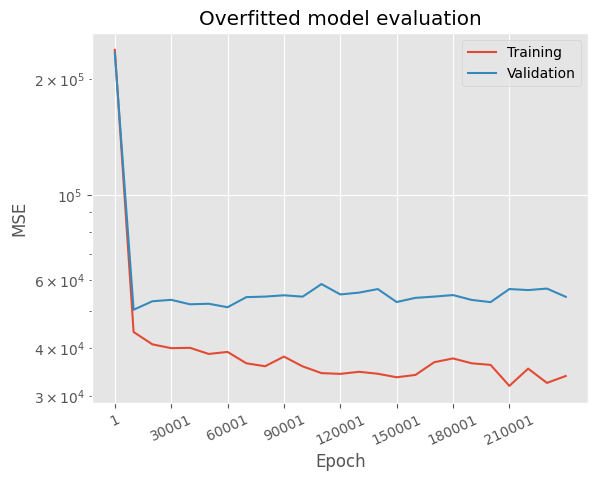

In [6]:
import matplotlib.pyplot as plt

train_losses_sampled = train_losses[::10000]  # Select every 1000th value
val_losses_sampled = val_losses[::10000]      # Select every 1000th value

# Generate corresponding epoch numbers, assuming epochs_suc is your list of epoch numbers
epochs_sampled = epochs_suc[::10000]

plt.style.use("ggplot")
plt.title("Overfitted model evaluation")


# Use sampled data for plotting
plt.plot(epochs_sampled, train_losses_sampled, label='Training')
plt.plot(epochs_sampled, val_losses_sampled, label='Validation')

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.yscale('log')
plt.xticks(
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    rotation = 25
)
plt.legend()
plt.show()
# plt.savefig("../visualizations/overfit_model_evaluation_full_dataset.png", dpi=800)

# Saving. Good results

In [ ]:
# class TabularFFNNSimple(nn.Module):
#     def __init__(self, input_size, output_size, dropout_prob=0.4):
#         super(TabularFFNNSimple, self).__init__()
#         hidden_size = 48
#         self.ffnn = nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.ReLU(),
# #             nn.BatchNorm1d(hidden_size),
# #             nn.Dropout(0.5),
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
# #             nn.Dropout(0.5),
#             nn.Linear(hidden_size, output_size)
#         )
        
#         for m in self.ffnn:
#             if isinstance(m, nn.Linear):
#                 init.xavier_uniform_(m.weight)
#                 m.bias.data.fill_(0)

#     def forward(self, x):
#         x = x.float()
#         # print(x)
#         x = x.view(x.size(0), -1)
#         x = self.ffnn(x)
#         return x
    
# # Split the data into features and target
# X = data.drop('price', axis=1)
# y = data['price']

# # Standardize the features
# device = torch.device("cpu")
# # Convert to PyTorch tensors
# X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
# y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


# # Split the data into training and combined validation and testing sets
# X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor,
#                                                             test_size=0.4, random_state=42)

# # Split the combined validation and testing sets
# X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# # Create DataLoader for training, validation, and testing
# train_data = TensorDataset(X_train, y_train)
# val_data = TensorDataset(X_val, y_val)
# test_data = TensorDataset(X_test, y_test)

# batch_size = 256
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# # Check if the dimensions match the expected input size for the model
# input_size = X_train.shape[1]

# # Output
# # input_size, train_loader, test_loader

# model = TabularFFNNSimple(
#     input_size = input_size,
#     output_size = 1
# )
# model.to(device)

# num_epochs = 300000
# train_losses = []
# val_losses = []
# epochs_suc = [] # to have a reference to it
# grad_norms = []

# def get_gradient_norm(model):
#     total_norm = 0
#     for p in model.parameters():
#         if p.grad is not None:
#             param_norm = p.grad.data.norm(2)
#             total_norm += param_norm.item() ** 2
#     total_norm = total_norm ** 0.5
#     return total_norm

# optimizer = optim.Adam(
#     model.parameters(), 
#     lr=9e-3,
#     weight_decay=1e-4
# )
# criterion = torch.nn.MSELoss()
# criterion_abs = torch.nn.L1Loss()
# criterion = criterion_abs

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     mode='min', 
#     factor=0.999999, 
#     patience=10, 
#     verbose=True
# )

# for epoch in range(num_epochs):
#     # Training
#     model.train()  # Set the model to training mode
#     running_loss = 0.0
#     l1_losses = []
#     grad_norm = 0
#     for tuple_ in train_loader:
#         datas, prices = tuple_
#         optimizer.zero_grad()
#         outputs = model(datas)
#         prices_viewed = prices.view(-1, 1).float()
#         loss = criterion(outputs, prices_viewed)
#         loss.backward()
#         grad_norm += get_gradient_norm(model)
#         optimizer.step()

#         running_loss += loss.item()
        
#     grad_norms.append(grad_norm / len(train_loader))
#     train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

#     # Validation
#     model.eval()  # Set the model to evaluation mode
#     val_loss = 0.0
#     with torch.no_grad():  # Disable gradient calculation
#         for tuple_ in val_loader:
#             datas, prices = tuple_
#             outputs = model(datas)  # Forward pass
#             prices_viewed = prices.view(-1, 1).float()
#             loss = criterion(outputs, prices_viewed)  # Compute loss
#             val_loss += loss.item()  # Accumulate the loss
#             l1_losses.append(criterion_abs(outputs, prices_viewed))

#     val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
#     l1_mean_loss = sum(l1_losses) / len(l1_losses)
#     # Print epoch's summary
#     epochs_suc.append(epoch)
#     scheduler.step(val_losses[-1])
#     if epoch % 100 == 0:
#         tl = f"Training Loss: {int(train_losses[-1])}"
#         vl = f"Validation Loss: {int(val_losses[-1])}"
#         l1 = f"L1: {int(l1_mean_loss)}"
#         dl = f'Epoch {epoch+1}, {tl}, {vl}, {grad_norms[-1]}'
#         print(dl)